# 环境测试

In [35]:
import tensorflow  as tf
# 使用显卡进行时，将GPU的显存使用策略设置为 “仅在需要时申请显存空间”,不然会申请所有显存空间，报错
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

返回运行时可见的物理设备列表，默认情况下，所有发现的CPU和GPU设备都被视为可见的。

In [36]:
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

查看GPU设备信息

In [37]:
!nvidia-smi

Tue May 19 23:17:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    19W / 175W |   4923MiB /  7979MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

检查GPU是否可用

In [5]:
tf.test.is_gpu_available()

True

查看GPU是否可用

In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# 启用设备放置日志记录将导致打印任何张量分配或操作
tf.debugging.set_log_device_placement(True)

In [6]:
tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)

VirtualDeviceConfiguration(memory_limit=1024)

# 数据处理

## 数据载入

+ CIFAR-10数据集

&emsp;&emsp;CIFAR-10数据集是一个用于识别普适物体的小型数据集，它一共包含10个类别的RGB彩色图片：飞机（airplane）、汽车（automobile）、鸟类（bird）、猫（cat）、鹿（deer）、狗（dog）、蛙类（frog）、马（horse）、船（ship）和卡车（truck）。图片的尺寸为32x32，该数据集一共有50000张训练图片和10000张测试图片。

&emsp;&emsp;1个10000x3072大小的uint8s数组。数组的每行存储1张32*32的图像,第1个1024包含红色通道值，下1个包含绿色，最后的1024包含蓝色。图像存储以行顺序为主，所以数组的前32列为图像第1行的红色通道值。

In [2]:
import pickle
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
class CIFAR10(object):
    
    def __init__(self,path='/home/wcjb/Code/Dataset/cifar-10-batches-py/'):
        self.trainpath = [os.path.join(path,'data_batch_'+str(i+1)) for i in range(5)]
        self.testpath = [os.path.join(path,'test_batch')]
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding = 'iso-8859-1') # 
        return dict
    
    def load_batch(self,file):
        
        with open(file, 'rb')as f:
            datadict = self.unpickle(file)
            data = datadict['data']
            label = datadict['labels']
            data = data.reshape(10000, 3, 32, 32)
            label = np.array(label)
            return data,label
        
    def toimg(self,data):
        img = []
        for i in range(data.shape[0]):
            imgs = data[i - 1]
            r = imgs[0]
            g = imgs[1]
            b = imgs[2]
            R = Image.fromarray(r)
            G = Image.fromarray(g)
            B = Image.fromarray(b)
            
            img.append(Image.merge("RGB",(R,G,B)))
        return img
            
        
    def cif2img(self):
        
        train_img,test_img = [],[]
    
        for tp in tqdm(self.trainpath,desc='Train-img'):
            
            data,label = self.load_batch(tp)
            train_img.append(self.toimg(data))
            
        for tp in tqdm(self.testpath,desc='Test-img '):
            
            data,label = self.load_batch(tp)
            test_img.append(self.toimg(data))
            
            
        return train_img,test_img
        
    def cif2data(self):
        
        x_train,y_train,x_test,y_test = [],[],[],[]
        for tp in tqdm(self.trainpath,desc='Train'):
            data,label = self.load_batch(tp)
            x_train.append(data)
            y_train.append(label)
        for tp in tqdm(self.testpath,desc='Test '):
            data,label = self.load_batch(tp)
            x_test.append(data)
            y_test.append(label)
        x_train,y_train = np.array(x_train).reshape(-1,3,32,32),np.array(y_train).reshape(-1,)
        x_test,y_test = np.array(x_test).reshape(-1,3,32,32),np.array(y_test).reshape(-1,)
        x_train,x_test = np.rollaxis(x_train, 1,4),np.rollaxis(x_test,1, 4)
        
        return x_train,y_train,x_test,y_test

In [3]:
cif = CIFAR10()
# 将CIFAR10数据集加载为图片数据
train_img,test_img = cif.cif2img()
# 将将CIFAR10数据集加载为多维数据用于训练
x_train,y_train,x_test,y_test = cif.cif2data()

Test : 100%|██████████| 1/1 [00:00<00:00, 40.89it/s]


## 特征工程

### 查看数据集样本的图片

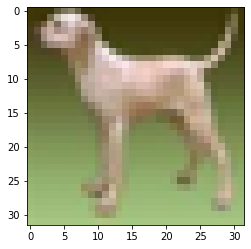

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_img[0][0])

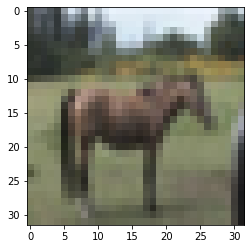

In [5]:
plt.imshow(test_img[0][0])

### 查看数据集的样本的数组形态

In [6]:
x_train.shape

(50000, 32, 32, 3)

### 数据增强处理函数

+ 直方图均衡化

&emsp;&emsp;直方图均衡化通常用来增加许多图像的全局对比度，尤其是当图像的有用数据的对比度相当接近的时候。通过这种方法，亮度可以更好地在直方图上分布。这样就可以用于增强局部的对比度而不影响整体的对比度，直方图均衡化通过有效地扩展常用的亮度来实现这种功能。这种方法对于背景和前景都太亮或者太暗的图像非常有用，这种方法尤其是可以带来X光图像中更好的骨骼结构显示以及曝光过度或者曝光不足照片中更好的细节。这种方法的一个主要优势是它是一个相当直观的技术并且是可逆操作，如果已知均衡化函数，那么就可以恢复原始的直方图，并且计算量也不大。这种方法的一个缺点是它对处理的数据不加选择，它可能会增加背景噪声的对比度并且降低有用信号的对比度。

In [7]:
import shutil
from PIL import Image
import sys
import cv2
from tqdm import notebook
class DataAugumentation(object):
    
    def __init__(self,num=10):
        
        self.num = num

    def CLAHE(self,img):
        grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 局部直方图均值化
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(grayimg)
        return cl1

    def Histograms_Equalization(self,img):
        
        grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 直方图均值化
        equ = cv2.equalizeHist(grayimg)
        return equ

    def make_one_hot(self,data):
        return (np.arange(self.num)==data[:,None]).astype(np.int64)
    
    def augument(self,imgs,labels):
        '''
        使用图像处理方法进行数据增强，直方图均值化和局部直方图均值化
        再加上灰度图和原图片可以将数据集增大三倍
        '''
        x_data,y_data = [],[]
        
        for img,label in notebook.tqdm(zip(imgs,labels),desc='数据增强进度'):
            
            imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            x_data.append(imggray.astype('float32') / 255.0)
            y_data.append(label)

            he_image = self.Histograms_Equalization(img)
            x_data.append(he_image.astype('float32') / 255.0)
            y_data.append(label)

            clahe_img = self.CLAHE(img)
            x_data.append(clahe_img.astype('float32') / 255.0)
            y_data.append(label)
            
        return np.array(x_data),np.array(y_data)

### 处理训练集

In [8]:
da = DataAugumentation()
x_new_train,y_new_train = da.augument(x_train,y_train)
x_new_test,y_new_test = da.augument(x_test,y_test)

+ 扩展数据维度，计算卷积

In [9]:
x_new_train = np.expand_dims(x_new_train, 3)
x_new_test = np.expand_dims(x_new_test,3)

可以看到，数据集增强之后比较大，所以可以把增强后的数据集保存在本地方便再次复用。

In [10]:
pickle.dump(x_new_train, open('./CifaData/x_new_train.p', 'wb'))
pickle.dump(y_new_train, open('./CifaData/y_new_train.p', 'wb'))
pickle.dump(x_new_test, open('./CifaData/x_new_test.p', 'wb'))
pickle.dump(y_new_test, open('./CifaData/y_new_test.p', 'wb'))

In [11]:
!cd CifaData && ls -hl

总用量 705M
-rw-rw-r-- 1 wcjb wcjb 118M 5月  19 22:17 x_new_test.p
-rw-rw-r-- 1 wcjb wcjb 586M 5月  19 22:17 x_new_train.p
-rw-rw-r-- 1 wcjb wcjb 235K 5月  19 22:17 y_new_test.p
-rw-rw-r-- 1 wcjb wcjb 1.2M 5月  19 22:17 y_new_train.p


In [29]:
# with open('./CifaData/y_new_train.p', 'rb') as fo:
#     y_n_train = pickle.load(fo, encoding = 'iso-8859-1')

# 搭建模型

In [21]:
import tensorflow as tf
import datetime
import time

MODEL_DIR = "./models"

class network(tf.keras.Model):
    
    def __init__(self,n_class=10,learning_rate=1e-4):
        
        super(network,self).__init__()
        
        # 定义网络结构
        self.conv2d_01 = tf.keras.layers.Convolution2D (kernel_size = (5, 5),input_shape=(32,32,1), filters = 100, activation='relu')
        self.maxpool2d_01 = tf.keras.layers.MaxPool2D()
        self.conv2d_02 = tf.keras.layers.Convolution2D (kernel_size = (3, 3), filters = 150, activation='relu')
        self.maxpool2d_02 = tf.keras.layers.MaxPool2D()
        self.conv2d_03 = tf.keras.layers.Convolution2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu')
        self.maxpool2d_03 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_01 = tf.keras.layers.Dense(512, activation='relu')
        self.dense_02 = tf.keras.layers.Dense(300, activation='relu')
        self.dense_03 = tf.keras.layers.Dense(10,activation='softmax')
        
        # 优化器
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        # 确认模型日志目录是否存在，若不存在则创建
        if not tf.io.gfile.exists(MODEL_DIR):
            tf.io.gfile.makedirs(MODEL_DIR)
        # 申明训练和测试日志路径
        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')
        
        # 根据给定文件在当前上下文环境中创建日志记录器，记录数据摘要，便于可视化及分析并且每个10000刷新
        self.train_summary_writer = tf.summary.create_file_writer(train_dir, flush_millis=10000)
        self.test_summary_writer = tf.summary.create_file_writer(test_dir, flush_millis=10000, name='test')
        
        # 将可追踪变量以二进制的方式储存成一个checkpoint 档(.ckpt)，
        # 即储存变量的名字和对应的张量的数值。
        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        
        self.checkpoint = tf.train.Checkpoint(model=self, optimizer=self.optimizer)
        # 只保存最近10个模型文件
        tf.train.CheckpointManager(self.checkpoint, directory=checkpoint_dir, checkpoint_name='network.ckpt', max_to_keep=10)
        # 返回目录下最近一次checkpoint的文件名，并恢复模型参数
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        
    def call(self,inputs):
        
        x = self.conv2d_01(inputs)
        x = self.maxpool2d_01(x)
        
        x = self.conv2d_02(x)
        x = self.maxpool2d_02(x)
        
        x = self.conv2d_03(x)
        x = self.maxpool2d_03(x)
        
        x = self.flatten(x)
      
        x = self.dense_01(x)
        x = self.dense_02(x)
        x = self.dense_03(x)
        
        return x
        
    @tf.function()
    def loss(self, logits, labels):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True))

    @tf.function()
    def accuracy(self, logits, labels):
        return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)
    
    @tf.function(experimental_relax_shapes=True)
    def train_step(self, images, labels):
        
        with tf.device('/GPU:0'):
            with tf.GradientTape() as tape:
                # 前向计算
                logits = self.call(images)
                # 计算当前批次模型的损失函数
                loss = self.loss(logits, labels)
                # 计算当前批次的模型准确率
                accuracy = self.accuracy(logits, labels)
            #=====================反向过程=====================
            # 计算梯度
            grads = tape.gradient(loss, self.trainable_variables)
            # 使用梯度更新可训练集合的变量
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            
        return loss, accuracy, logits

    def train(self, train_dataset, test_dataset, epochs=1, log_freq=50):
        
        for i in range(epochs):
            
            train_start = time.time()
            # 在该上下文环境中记录可追踪变量
            with self.train_summary_writer.as_default():
                
                start = time.time()
               # metrics指标是有状态的。当调用.result()时，会计算累计值并返回累计的结果。使用.reset_states()可以清除累积值
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)  
                avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)  

                for images, labels in train_dataset:

                    loss, accuracy, logits = self.train_step(images, labels)
                    # 持续纪律损失值
                    avg_loss(loss)
                    # 持续记录分类正确率
                    avg_accuracy(accuracy)
                    # 在训练log_freq次后，记录变量，并计算累计指标值
                    # optimizer.iterations 记录了优化器运行的训练步数
                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        # 在日志中写入变量的摘要
                        tf.summary.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        tf.summary.scalar('accuracy', avg_accuracy.result(), step=self.optimizer.iterations)
                        # 计算完成一个批次训练所需要的时间
                        rate = log_freq / (time.time() - start)
                        print('Step{} Loss: {:0.4f} accuracy: {:0.2f}% ({:0.2f} steps/sec)'.format(self.optimizer.iterations.numpy(), loss, (avg_accuracy.result() * 100), rate))
                        
                        # 清除当前训练批次的指标累计值，进入下一训练批次
                        avg_loss.reset_states()
                        avg_accuracy.reset_states()
                        start = time.time()

            train_end = time.time()
            
            print('\nTrain time for epoch: {} ({} total steps): {}'.format(i + 1, self.optimizer.iterations.numpy(), train_end - train_start))
            
            with self.test_summary_writer.as_default():
                self.test(test_dataset, self.optimizer.iterations)
            # 保存当前epoch的模型参数
            self.checkpoint.save(self.checkpoint_prefix)
            #在训练后保存模型会报错，暂时没有解决
#         self.export_path = os.path.join(MODEL_DIR, 'export')
#         tf.saved_model.save(self, self.export_path)
        
    
    def test(self, test_dataset, step_num):
        """
        评估模型在验证集上的正确率
        """
        
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)
        # 只需要计算前向过程,需要计算相应指标
        for (images, labels) in test_dataset:
            logits = self.call(images)
            avg_loss(self.loss(logits, labels))
            avg_accuracy(self.accuracy(logits, labels))

        print('Test-Loss: {:0.4f} Test-Accuracy: {:0.2f}%'.format(avg_loss.result(), avg_accuracy.result() * 100))
        tf.summary.scalar('loss', avg_loss.result(), step=step_num)
        tf.summary.scalar('accuracy', avg_accuracy.result(), step=step_num)
            
    def evaluat(self, test_dataset):
        # 模型保存报错，暂未解决,故无法读取
#         restored_model = tf.saved_model.restore(self.export_path)
#         y_predict = restored_model(x_test)
        avg_accuracy = tf.keras.metrics.Mean('accuracy', dtype=tf.float32)

        for (images, labels) in test_dataset:
            logits = self.call(images)
            avg_accuracy(self.accuracy(logits, labels))

        print('Model accuracy: {:0.2f}%'.format(avg_accuracy.result() * 100))

    def forward(self, xs):
        """
        完成模型的前向计算，用于实际预测
        """
        predictions = self.call(xs)
        logits = tf.nn.softmax(predictions)

        return logits
    

使用tf.data.Dataset创建可迭代访问的数据集，便于按批次进行训练

In [24]:
# 由于是在显卡在进行训练，不过不是大显存请使用较小的Batch Size
val_dataset = tf.data.Dataset.from_tensor_slices((x_new_test.astype(np.float32), y_new_test))
val_dataset = val_dataset.shuffle(10000).batch(1024)

dataset = tf.data.Dataset.from_tensor_slices((x_new_train.astype(np.float32), y_new_train))
dataset = dataset.shuffle(5000).batch(1024)  

In [25]:
net = network()
net.train(dataset, val_dataset,1)

Step72550 Loss: 1.5211 accuracy: 94.14% (13.43 steps/sec)
Step72600 Loss: 1.5097 accuracy: 94.07% (15.38 steps/sec)
Step72650 Loss: 1.5188 accuracy: 94.38% (15.44 steps/sec)

Train time for epoch: 1 (72666 total steps): 11.80623173713684
Test-Loss: 1.7723 Test-Accuracy: 68.68%


In [32]:
net.forward(x_new_train[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.0853368 , 0.0853368 , 0.0853368 , 0.08533724, 0.0853368 ,
        0.0853368 , 0.23196831, 0.0853368 , 0.0853368 , 0.0853368 ]],
      dtype=float32)>

In [34]:
y_new_train[:1]

array([6])

In [26]:
!cd models/checkpoints/ && ls -lh

总用量 3.4G
-rw-rw-r-- 1 wcjb wcjb   73 5月  19 23:11 checkpoint
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  19 11:41 ckpt-100.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  19 11:41 ckpt-100.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  19 11:41 ckpt-100.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  19 11:41 ckpt-101.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  19 11:41 ckpt-101.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  19 11:41 ckpt-101.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  19 11:41 ckpt-102.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  19 11:41 ckpt-102.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  19 11:41 ckpt-102.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  19 11:41 ckpt-103.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  19 11:41 ckpt-103.data-00001-of-00002
-rw-rw-r-- 1 wcjb wcjb 3.0K 5月  19 11:41 ckpt-103.index
-rw-rw-r-- 1 wcjb wcjb 5.0K 5月  19 11:41 ckpt-104.data-00000-of-00002
-rw-rw-r-- 1 wcjb wcjb  21M 5月  19 11:41 ckpt-104.data-00001-of-00002
-rw-rw-r-- 1 wc